# Classifying Fashion-MNIST

Now it's your turn to build and train a neural network. You'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's load the dataset through torchvision.

In [21]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
data_stream = torch.cuda.Stream()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Here we can see one of the images.

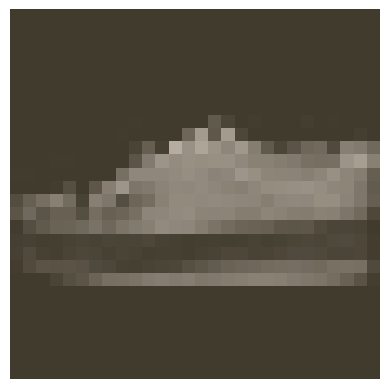

In [22]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [16]:
from torch import nn, optim

In [23]:
# TODO: Define your network architecture here
# Hyperparameters for our network
img_xy_dims = image.shape[-2:]
input_size = img_xy_dims[0] * img_xy_dims[1]
hidden_sizes = [256, 128, 64]
output_size = 10
layer_sizes = [input_size] + hidden_sizes + [output_size]

In [24]:
class F_MNIST_Classifier(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList()
        for n in range(len(layer_sizes)-1): # 1-pad and step in pairs
            self.layers.append(nn.Linear(layer_sizes[n], layer_sizes[n+1]))
            if n == len(layer_sizes)-2: # last layer
                self.layers.append(nn.LogSoftmax(dim=1))
            else:
                self.layers.append(nn.ReLU())
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)  # Linear and ReLU layers applied sequentially
        return x

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# TODO: Create the network, define the criterion and optimizer
model = F_MNIST_Classifier(layer_sizes=layer_sizes).to(device=device)
print(model)

learning_rate = 0.003
momentum = 0.42

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=learning_rate, momentum=momentum)

F_MNIST_Classifier(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)


In [26]:
# TODO: Train the network here

epochs = 5
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        with torch.cuda.stream(data_stream):
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
        data_stream.synchronize()
        
        # images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)
        optimizer.zero_grad() #GO ; 0G

        output = model(images) # Forward
        loss = criterion(output, labels) # Loss
        loss.backward() # Gradient
        optimizer.step() # Optimizer step

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")
   

Training loss: 1.7552931097143494
Training loss: 0.780989396514923
Training loss: 0.62434487677078
Training loss: 0.5615536140671162
Training loss: 0.5216272155613279


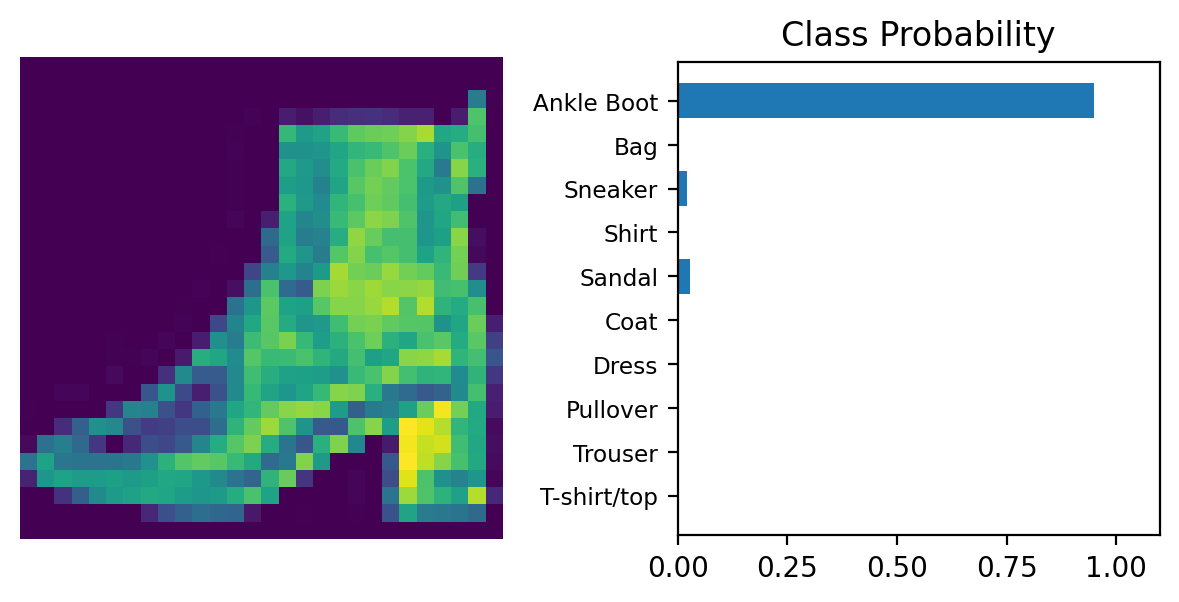

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784).to(device)

# TODO: Calculate the class probabilities (softmax) for img
with torch.no_grad():
    logps = model(img)
ps = torch.exp(logps)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28).cpu(), ps.cpu(), version='Fashion')